# Item based collaborative filtering
## Abstract
Item based collaborative filtering assumes 2 things:
1. Among items that Arice has not evaluated (= recommendation candidate), the likelihood of liking it is likely to be similar to the item highly liked by Alice.
2. If the items being evaluated are similar to each other, it can be said that the items are similar.
So calculates the similarity between items from the user's behavior and calculates mainly the similarity of the items.
The algorithm is shown below.

$$
\begin{equation}
     {\hat{\gamma}}_{uy} = \frac{
        \Sigma_{j\in{Y_u}}  S_{yj} \gamma_{uj}
    }{
        \Sigma_{j\in{Y_u}} |S_{yj}|
    }
\end{equation}
$$

where:

$\hat{\gamma_{uy}}$ : Prediction that User $u$ evaluate Item $y$  
$S_{yj}$ : Similarity between Item $y$ and Item 'j'  
$Y_u$ : Set of items evaluated by User $u$  
$Y_uj$ : Evaluation that User $u$ 's Item $j$  

## Imagine the similarity between items
__buy or not__

|    |   a   |   b   |   c   |   d   |   e   |
| :-: | -----: | -----: | -----: | -----: | -----: |
| A |      |        |   1   |       |   1   |
| B |       |       |    1    |   1   |   1   |
| C |   1   |   1   |       |       |       |
| D |       |   1   |   1   |     |   1   |
| E |   1   |       |   1   |   1   |      |

__Number of combinations of products purchased by the same person__

|    |   a   |   b   |   c   |   d   |   e   |
| :-: | -----: | -----: | -----: | -----: | -----: |
| a |   -    |   1    |   2   |       |       |
| b |   1   |   -     |   1   |       |       |
| c |   2   |   1    |    -    |   1   |   2   |
| d |       |        |   1    |    -   |   1   |
| e |       |        |   2    |   1   |    -    |

__Calculate the ratio purchased by set from the sum of the combination__

|    |   a   |   b   |   c   |   d   |   e   |
| :-: | -----: | -----: | -----: | -----: | -----: |
| a |    |    |    |    |    |
| b |    |    |    |    |    |
| c |    |    |    |    |    |
| d |    |    |    |    |    |
| e |    |    |    |    |    |

Let's try it yourself.
You can refer like below:
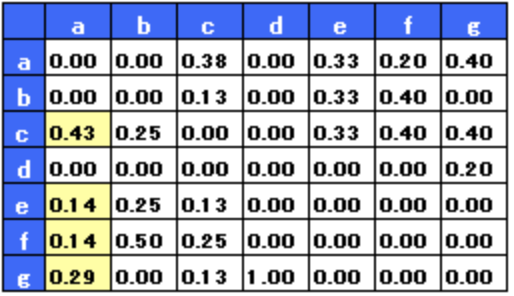

__Order item pair by similarity__

|   item_1   |   item_2   |   Percentage to be bought  as pair   | 
| :--: | :---: | :---: |
| a | c  |  34%  |  
|a  |  d  |  32%  |
| c |  e  |  29%  | 
| b | c   |  24%  |
| c |  d  |  20%  |

It is dummy sorry

## How to calc similarity?
In case of IBCF, `cosine similarity` is often used.


## Let's implement!
### 1st. Pre-processing
I used data [MovieLens 100K Dataset](http://grouplens.org/datasets/movielens/100k/) .
Firstly, transform data to matrix.

In [85]:
import os
print(os.getcwd()) # if it show the path like '....../tech_note_for_machine_learning/data/ml-100k', it is ok without below
os.chdir('../../data/ml-100k')

/Users/maki/dev/src/github.com/simula-labs/tech_note_for_machine_learning/data/ml-100k


In [86]:
import numpy as np
import pandas as pd
from scipy import sparse

df = pd.read_csv('u.data', sep='\t', names=['user_id','item_id', 'rating', 'timestamp'])
shape = (df.max().ix['user_id'] , df.max().ix['item_id'] )
CROSS = sparse.lil_matrix(shape) 

for i in df.index:
    row = df.ix[i]
    CROSS[row['user_id'] - 1, row['item_id'] - 1] = row['rating']

/Users/maki/.pyenv/versions/anaconda3-4.3.0/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/maki/.pyenv/versions/anaconda3-4.3.0/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [87]:
CROSS = CROSS.toarray()

In [88]:
CROSS

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

### 2nd. Create Model

In [89]:
# Maintainer: mackeee-orange <makino.aaa@gmail.com>
import numpy as np
import pandas as pd
from math import sqrt
import os


class IBCollaborativeFiltering:
    def __init__(self, CROSS):
        self.cross = CROSS      # user * item
        self.item_similarity = None
        self.users = None

    def calc_sim(self):
        sims = self._calculate_item_similarity()
        return sims

    def predict(self, u, sims):
        """
        自分にセットされたやつでもいいし，新たにユーザーとクロスをセットしてもいい
        :param u:
        :param sims:
        :return prediction:
        """
        prediction = None
        # 未評価は0, 評価済は1となるベクトル=>normalizersのため
        if self.users and self.item_similarity:
            x = np.zeros(u.size)
            x[u > 0] = 1

            scores = sims.dot(u)
            normalizers = sims.dot(x)

            prediction = np.zeros(u.size)
            for i in range(u.size):
                # 分母が 0 になるケースと評価済アイテムは予測値を 0 とする
                if normalizers[i] == 0 or u[i] > 0:
                    prediction[i] = 0
                else:
                    prediction[i] = scores[i] / normalizers[i]
        else:
            x = np.zeros(u.size)
            x[u > 0] = 1

            scores = sims.dot(u)
            normalizers = sims.dot(x)

            prediction = np.zeros(u.size)
            for i in range(u.size):
                # 分母が 0 になるケースと評価済アイテムは予測値を 0 とする
                if normalizers[i] == 0 or u[i] > 0:
                    prediction[i] = 0
                else:
                    prediction[i] = scores[i] / normalizers[i]

        # ユーザ u のアイテム i に対する評価の予測
        return prediction

    def _calculate_item_similarity(self, calc_type='cosine'):
        """
        アイテム類似度の計算
        :param calc_type: [cosine, ] 一応コサイン以外も対応して行きたいから用意しておく
        :return: sims
        """
        # n: movie counts
        n = self.cross.shape[1]
        sims = np.zeros((n, n))

        if calc_type is 'cosine':
            for i in range(n):
                for j in range(i, n):
                    if i == j:
                        sim = 1.0
                    else:
                        # self.cross[:, i] は アイテム i に関する全ユーザの評価を並べた列ベクトル
                        sim = self._cosine_similarity(self.cross[:, i], self.cross[:, j])

                    sims[i][j] = sim
                    sims[j][i] = sim

        self.item_similarity = sims
        return sims

    def _cosine_similarity(self, item1, item2):
        # item1 と item2 のどちらも評価済であるユーザの集合
        common = np.logical_and(item1 != 0, item2 != 0)
        v1 = item1[common]
        v2 = item2[common]

        sim = 0.0
        # 共通評価者が 2以上という制約
    
        if v1.size > 1:
            sim = 1.0 - self._cosine(v1, v2)

        return sim

    def _cosine(self, item_1, item_2):
        """
        コサイン類似度を計算します
        :param item_1: matrix as ndarray
        :param item_2: matrix as ndarray
        :return sim: similarity
        """
        # A*B
        ab = np.dot(item_1, item_2)

        # |A| and |B|
        a_norm = sqrt(sum([v ** 2 for v in item_1]))
        b_norm = sqrt(sum([v ** 2 for v in item_2]))
        sim = float(ab / (a_norm * b_norm))
        return sim

### 3rd. Calc similarity among items

In [90]:
ibcf = IBCollaborativeFiltering(CROSS)
ibcf.calc_sim()

array([[1.        , 0.05126261, 0.08670028, ..., 0.        , 0.        ,
        0.        ],
       [0.05126261, 1.        , 0.09112029, ..., 0.        , 0.        ,
        0.        ],
       [0.08670028, 0.09112029, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

### 4th. Predict sample

In [91]:
u = np.array([5, 0, 1])
sims = np.array([ [1, 0.2, 0], [0.2, 1, 0.1], [0, 0.1, 1] ])
ibcf.predict(u, sims)

array([0.        , 3.66666667, 0.        ])